# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

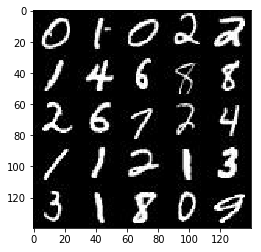

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

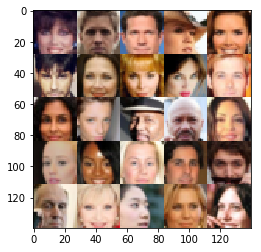

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32,name='lr')
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer = tf.contrib.layers.xavier_initializer())
        norm1 = tf.layers.batch_normalization(conv1, training=True)
        relu1 = tf.maximum(alpha * norm1, norm1)
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer = tf.contrib.layers.xavier_initializer())
        norm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * norm2, norm2)
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',kernel_initializer = tf.contrib.layers.xavier_initializer())
        norm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * norm3, norm3)
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    reuse=not is_train
    with tf.variable_scope('generator', reuse=reuse):
        fc0 = tf.layers.dense(z, 3*3*256)
        fc0 = tf.reshape(fc0, (-1, 3, 3, 256))
        norm0 = tf.layers.batch_normalization(fc0, training=is_train)
        relu0 = tf.maximum(alpha * norm0, norm0)
        deconv1 = tf.layers.conv2d_transpose(relu0, 128, 3, strides=2, padding='valid',kernel_initializer = tf.contrib.layers.xavier_initializer())
        norm1 = tf.layers.batch_normalization(deconv1, training=is_train)
        relu1 = tf.maximum(alpha * norm1, norm1)
        deconv2 = tf.layers.conv2d_transpose(relu1, 64, 5, strides=2, padding='same',kernel_initializer = tf.contrib.layers.xavier_initializer())
        norm2 = tf.layers.batch_normalization(deconv2, training=is_train)
        relu2 = tf.maximum(alpha * norm2, norm2)
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='same',kernel_initializer = tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
        
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1

    # Build the model
    g_model = generator(input_z, out_channel_dim)
    # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vars = tf.trainable_variables()
    d_vars = [var for var in vars if var.name.startswith('discriminator')]
    g_vars = [var for var in vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    #lr=learning_rate
           
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps=0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Run optimizers
                
                steps += 1
                batch_images*=2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
               
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,lr:learning_rate})
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4356... Generator Loss: 4.6296
Epoch 1/2... Discriminator Loss: 0.7278... Generator Loss: 3.9739
Epoch 1/2... Discriminator Loss: 1.5715... Generator Loss: 9.0218
Epoch 1/2... Discriminator Loss: 0.5539... Generator Loss: 3.9852
Epoch 1/2... Discriminator Loss: 0.5550... Generator Loss: 2.5220
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 2.8555
Epoch 1/2... Discriminator Loss: 0.8227... Generator Loss: 3.0438
Epoch 1/2... Discriminator Loss: 0.5959... Generator Loss: 2.1860
Epoch 1/2... Discriminator Loss: 0.6822... Generator Loss: 1.8439
Epoch 1/2... Discriminator Loss: 0.7732... Generator Loss: 1.4144


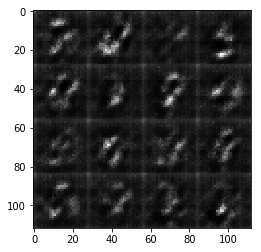

Epoch 1/2... Discriminator Loss: 0.7091... Generator Loss: 2.3712
Epoch 1/2... Discriminator Loss: 0.8467... Generator Loss: 1.2616
Epoch 1/2... Discriminator Loss: 0.6921... Generator Loss: 2.0330
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 3.3568
Epoch 1/2... Discriminator Loss: 0.8014... Generator Loss: 1.3834
Epoch 1/2... Discriminator Loss: 0.9687... Generator Loss: 1.0260
Epoch 1/2... Discriminator Loss: 0.8270... Generator Loss: 2.2646
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 0.7345... Generator Loss: 1.7488
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 1.4776


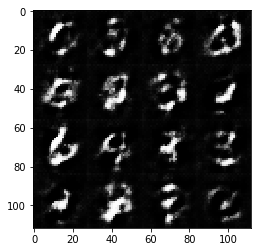

Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 1.7328
Epoch 1/2... Discriminator Loss: 0.8191... Generator Loss: 1.8242
Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 0.8923
Epoch 1/2... Discriminator Loss: 0.7820... Generator Loss: 1.6515
Epoch 1/2... Discriminator Loss: 1.0394... Generator Loss: 0.8978
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 1.3503
Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 0.9849
Epoch 1/2... Discriminator Loss: 0.7912... Generator Loss: 1.7662
Epoch 1/2... Discriminator Loss: 0.7868... Generator Loss: 1.8617
Epoch 1/2... Discriminator Loss: 0.8718... Generator Loss: 1.3471


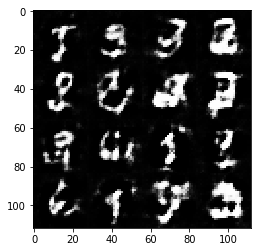

Epoch 1/2... Discriminator Loss: 0.8461... Generator Loss: 2.2752
Epoch 1/2... Discriminator Loss: 0.8163... Generator Loss: 1.1931
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 3.4343
Epoch 1/2... Discriminator Loss: 0.8345... Generator Loss: 1.2333
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 2.8134
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 0.8550
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 1.6753
Epoch 1/2... Discriminator Loss: 0.8789... Generator Loss: 1.3877
Epoch 1/2... Discriminator Loss: 0.9335... Generator Loss: 1.1093
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 0.6746


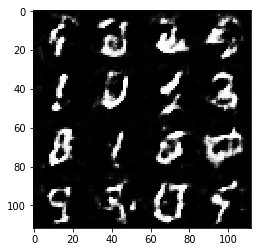

Epoch 1/2... Discriminator Loss: 1.0344... Generator Loss: 0.8870
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 0.8379... Generator Loss: 2.4638
Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 1.4043
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 3.2477
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 2.0756
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 2.4454
Epoch 1/2... Discriminator Loss: 1.0538... Generator Loss: 2.6839
Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 2.0966


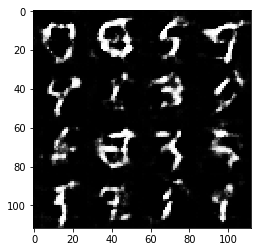

Epoch 1/2... Discriminator Loss: 0.9449... Generator Loss: 2.4931
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 1.4572
Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 1.1004
Epoch 1/2... Discriminator Loss: 1.3854... Generator Loss: 3.4667
Epoch 1/2... Discriminator Loss: 0.8216... Generator Loss: 2.0986
Epoch 1/2... Discriminator Loss: 0.9694... Generator Loss: 2.6991
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 1.3364
Epoch 1/2... Discriminator Loss: 0.8947... Generator Loss: 1.7293
Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 2.3308
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 2.7806


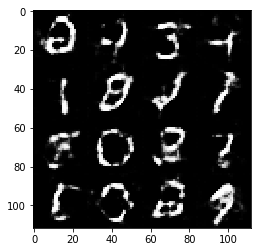

Epoch 1/2... Discriminator Loss: 0.8301... Generator Loss: 1.6671
Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 0.9602
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 0.7353
Epoch 1/2... Discriminator Loss: 0.8073... Generator Loss: 1.4093
Epoch 1/2... Discriminator Loss: 0.8656... Generator Loss: 1.1572
Epoch 1/2... Discriminator Loss: 0.7786... Generator Loss: 1.4731
Epoch 1/2... Discriminator Loss: 0.8201... Generator Loss: 1.7566
Epoch 1/2... Discriminator Loss: 0.8108... Generator Loss: 1.4308
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 1.3118
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 1.6046


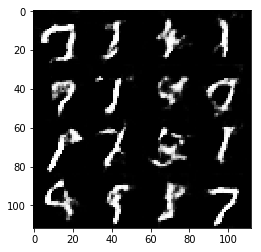

Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 1.5868
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 1.3012
Epoch 1/2... Discriminator Loss: 0.7925... Generator Loss: 1.4423
Epoch 1/2... Discriminator Loss: 1.1970... Generator Loss: 0.6366
Epoch 1/2... Discriminator Loss: 0.8942... Generator Loss: 1.5638
Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 1.5350
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.2842
Epoch 1/2... Discriminator Loss: 0.8949... Generator Loss: 1.8862
Epoch 1/2... Discriminator Loss: 0.7815... Generator Loss: 1.9515
Epoch 1/2... Discriminator Loss: 0.7523... Generator Loss: 1.6613


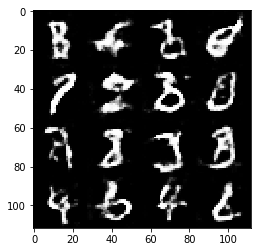

Epoch 1/2... Discriminator Loss: 0.8759... Generator Loss: 1.8918
Epoch 1/2... Discriminator Loss: 0.8549... Generator Loss: 2.0323
Epoch 1/2... Discriminator Loss: 0.8075... Generator Loss: 1.5264
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 1.7826
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.5902
Epoch 1/2... Discriminator Loss: 0.8365... Generator Loss: 1.5643
Epoch 1/2... Discriminator Loss: 0.8237... Generator Loss: 1.1864
Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 1.9261
Epoch 1/2... Discriminator Loss: 0.8191... Generator Loss: 1.9258


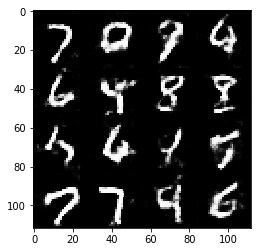

Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.9735
Epoch 1/2... Discriminator Loss: 0.8317... Generator Loss: 1.9214
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 1.2745
Epoch 2/2... Discriminator Loss: 0.8463... Generator Loss: 1.6198
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.9635
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 1.0160
Epoch 2/2... Discriminator Loss: 0.8876... Generator Loss: 2.0611
Epoch 2/2... Discriminator Loss: 0.8186... Generator Loss: 1.2235
Epoch 2/2... Discriminator Loss: 1.0748... Generator Loss: 2.6423
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 2.1451
Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 0.9845
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 1.6433
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 2.0990


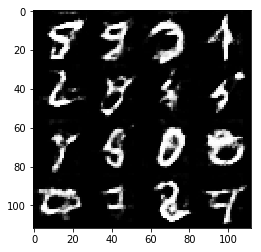

Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 2.0416
Epoch 2/2... Discriminator Loss: 1.5294... Generator Loss: 0.4313
Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 0.9873
Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 2.6689
Epoch 2/2... Discriminator Loss: 0.8628... Generator Loss: 2.3445
Epoch 2/2... Discriminator Loss: 0.7828... Generator Loss: 1.6704
Epoch 2/2... Discriminator Loss: 0.8131... Generator Loss: 1.1846
Epoch 2/2... Discriminator Loss: 0.8294... Generator Loss: 1.2277
Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 2.3542
Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 1.7969


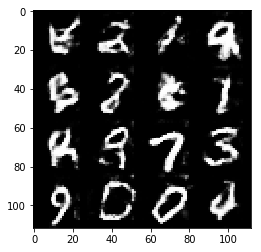

Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 1.1544
Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 1.3017
Epoch 2/2... Discriminator Loss: 1.1179... Generator Loss: 2.6796
Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 1.1111
Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 2.1133
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 0.8092
Epoch 2/2... Discriminator Loss: 0.9849... Generator Loss: 0.9253
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 1.5871


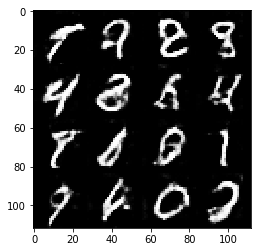

Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 2.1758
Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 1.4358
Epoch 2/2... Discriminator Loss: 0.9036... Generator Loss: 1.1010
Epoch 2/2... Discriminator Loss: 1.2624... Generator Loss: 0.6123
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.3418
Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 2.2301
Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 1.5037
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.2722
Epoch 2/2... Discriminator Loss: 0.8006... Generator Loss: 1.4998
Epoch 2/2... Discriminator Loss: 0.9888... Generator Loss: 2.4068


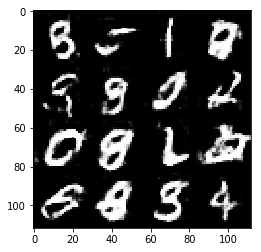

Epoch 2/2... Discriminator Loss: 0.7145... Generator Loss: 1.3498
Epoch 2/2... Discriminator Loss: 0.7668... Generator Loss: 1.3896
Epoch 2/2... Discriminator Loss: 0.7575... Generator Loss: 1.9212
Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 1.5297
Epoch 2/2... Discriminator Loss: 0.7819... Generator Loss: 2.1604
Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.8131
Epoch 2/2... Discriminator Loss: 0.8257... Generator Loss: 1.1564
Epoch 2/2... Discriminator Loss: 1.5326... Generator Loss: 3.3433
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.7305
Epoch 2/2... Discriminator Loss: 1.0453... Generator Loss: 2.5269


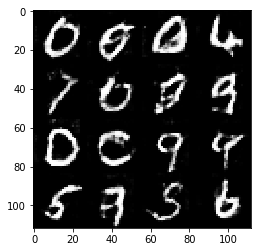

Epoch 2/2... Discriminator Loss: 0.7575... Generator Loss: 2.2556
Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 1.7152
Epoch 2/2... Discriminator Loss: 1.1873... Generator Loss: 0.6462
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 2.3342
Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 1.4610
Epoch 2/2... Discriminator Loss: 0.9837... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 1.1399
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 1.8175
Epoch 2/2... Discriminator Loss: 0.7992... Generator Loss: 1.2736
Epoch 2/2... Discriminator Loss: 0.8294... Generator Loss: 1.5397


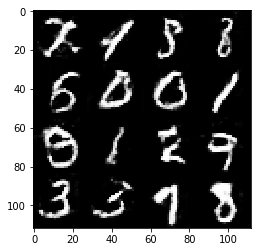

Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 2.0394
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 0.9282
Epoch 2/2... Discriminator Loss: 0.7240... Generator Loss: 1.7651
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 3.2251
Epoch 2/2... Discriminator Loss: 0.8362... Generator Loss: 1.6811
Epoch 2/2... Discriminator Loss: 0.9615... Generator Loss: 2.2007
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 1.7821
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 2.0078
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 1.8306
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 1.6394


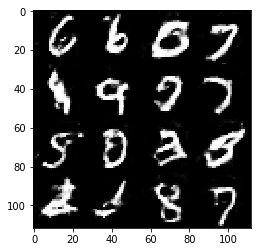

Epoch 2/2... Discriminator Loss: 0.7904... Generator Loss: 1.2180
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 2.2404
Epoch 2/2... Discriminator Loss: 0.7932... Generator Loss: 1.9645
Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 0.9449
Epoch 2/2... Discriminator Loss: 0.7990... Generator Loss: 1.9045
Epoch 2/2... Discriminator Loss: 0.9705... Generator Loss: 2.4625
Epoch 2/2... Discriminator Loss: 0.8476... Generator Loss: 1.2289
Epoch 2/2... Discriminator Loss: 0.8046... Generator Loss: 2.0146
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 2.6599
Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 1.5933


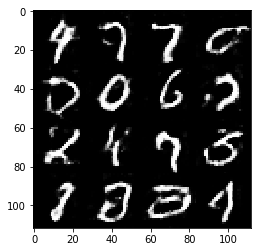

Epoch 2/2... Discriminator Loss: 0.8132... Generator Loss: 1.3587
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 1.7083
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 1.8028
Epoch 2/2... Discriminator Loss: 0.9503... Generator Loss: 2.2631
Epoch 2/2... Discriminator Loss: 0.7754... Generator Loss: 1.7028
Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 1.1252... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 0.7634... Generator Loss: 1.8265
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 1.8530
Epoch 2/2... Discriminator Loss: 0.9489... Generator Loss: 2.2226


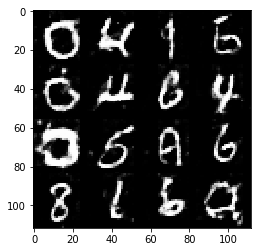

Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 1.9956
Epoch 2/2... Discriminator Loss: 0.7767... Generator Loss: 1.4344
Epoch 2/2... Discriminator Loss: 0.7759... Generator Loss: 1.2857


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4788... Generator Loss: 5.4387
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 4.8555
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 9.5977
Epoch 1/1... Discriminator Loss: 0.5632... Generator Loss: 4.4911
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 4.0906
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 2.4975
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 4.8129
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 3.3466
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 2.2309
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 2.9015


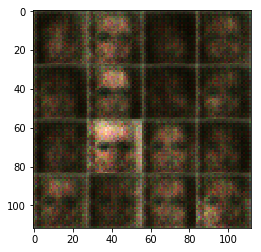

Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 2.3446
Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 2.7979
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 2.9169
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 3.8640
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 4.3501
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 2.2581
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 2.5596
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 1.2951
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 2.1599
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 3.1522


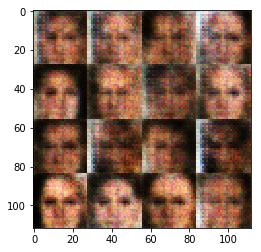

Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.3439
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 2.0627
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 3.2100
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 2.6485
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 2.5661
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 2.7501
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.8353
Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 2.1490
Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 2.1385
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.9474


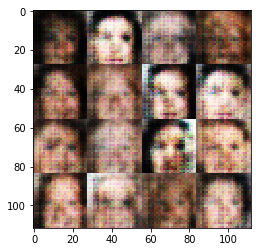

Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 3.4450
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 2.9609
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 2.1237
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.3763
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.8789
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 2.8261
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 3.0803
Epoch 1/1... Discriminator Loss: 0.8058... Generator Loss: 1.7748
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 2.5542


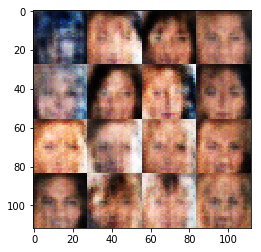

Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.9758
Epoch 1/1... Discriminator Loss: 0.7825... Generator Loss: 1.6152
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 1.5682
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 2.0125
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.8147
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.7903
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.6566
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.9804
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.6817
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.3345


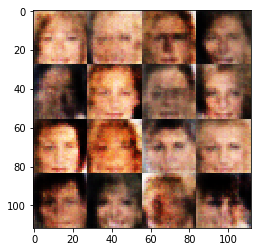

Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 1.9475
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.8125
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 1.4392
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.5268
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.9695
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.7499
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.6378
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.4371
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.7312


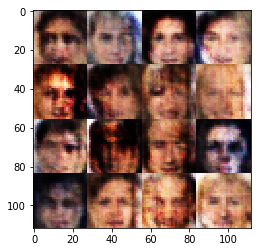

Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 1.5988
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.7626
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.4703
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.2833
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 2.1992
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.7080
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.6670
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.1420
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.5471


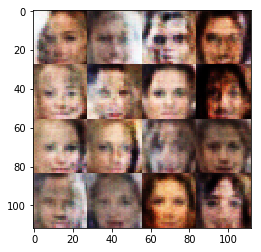

Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 2.0916
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.5302
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 1.4350
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 1.3987
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.6392
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.9169
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.6617
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.9382


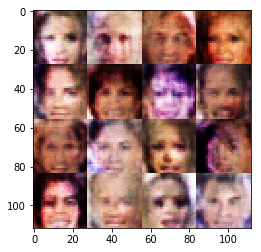

Epoch 1/1... Discriminator Loss: 0.9522... Generator Loss: 1.2615
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.5710
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.3080
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.5347
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.5269
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.4388
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.1671
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 1.8279
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.3718


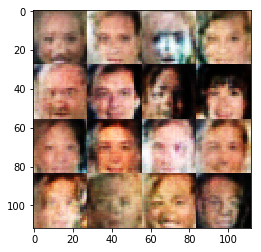

Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 0.9920... Generator Loss: 1.5571
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.4118
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 1.6741
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.5887
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.5825


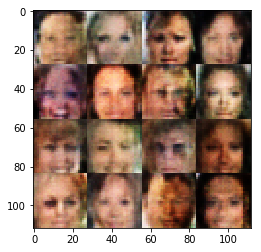

Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.1650
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.5731
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 1.1919
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.3512
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.7173
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 1.2855


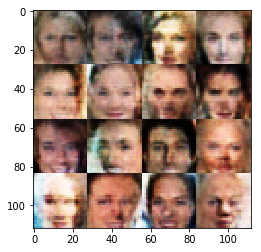

Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 2.2068
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.4744
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 1.4635
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.5814
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.4141
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 2.1201
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.2916


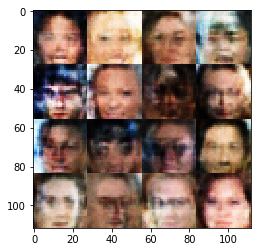

Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.1824
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.2835
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.8990


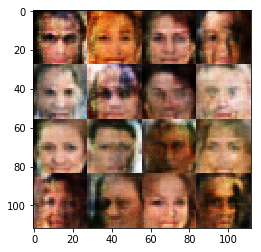

Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.6980
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 1.2796
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 1.2579
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 1.4457


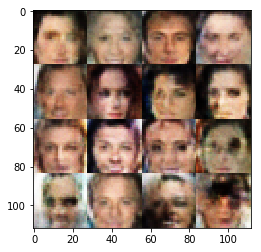

Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 1.0980
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 1.7596
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.4119
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.3301
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.3516


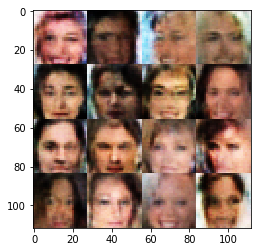

Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.2066
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.6107
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.2962


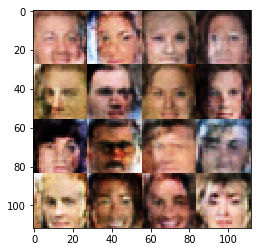

Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.3922
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 1.3908
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.1052
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.5554
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.1547


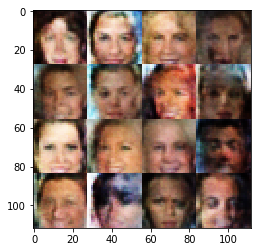

Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.3928
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.2977
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.2878
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 1.0973


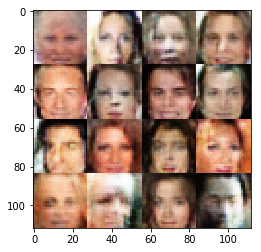

Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.6488
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.3480
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.5260
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 1.3683
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.0640
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.3780
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.2030


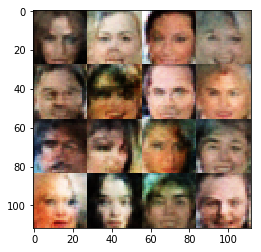

Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.1913
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.1189
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.1291
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 1.2179


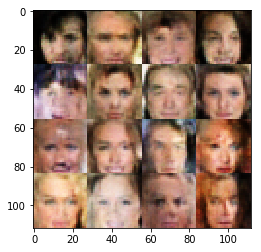

Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.1741
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.0508... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.2168
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.3859


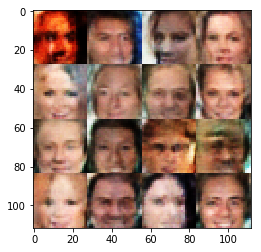

Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.3466
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.1504
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.2694
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.1616


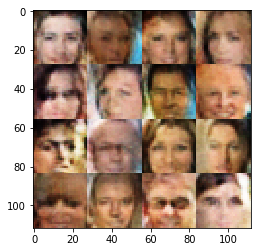

Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.2100
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.4492
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 1.3655
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.0903


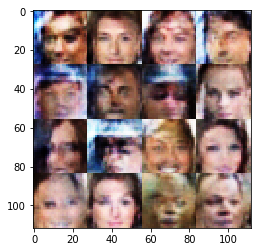

Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.3450
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.2477
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.3517
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.2080
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.3639
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 1.0659
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.2390


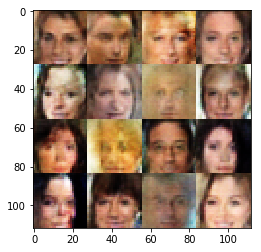

Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.2683
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.2318
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 1.5084
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.1617


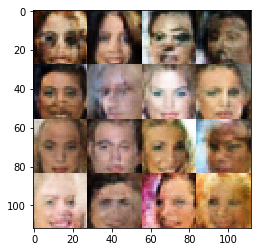

Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.1578
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 1.1616
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.2606
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.4388
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.9673


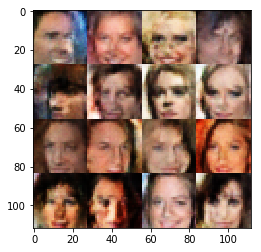

Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 1.5066
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.2013
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 0.9953
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.2164
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.6071
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.2092


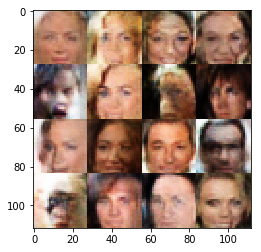

Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 1.0896
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 1.4575
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 1.3092
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 1.2162
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 1.3103


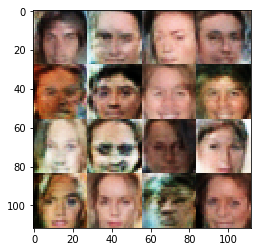

Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.3231
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.9972
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.3818
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 1.0496


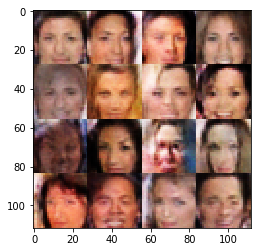

Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 1.0760


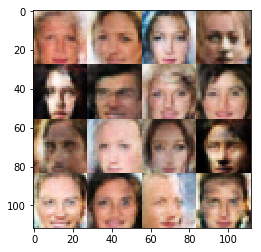

Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.2996
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 1.1028
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 1.0147


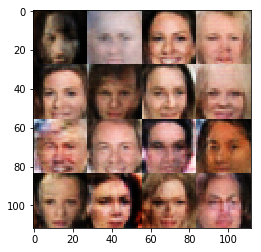

Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.1970
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.1130


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.